In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [8]:
runs = [304125,304508,302263]
bad_runs = [305588,301480]

with open('unscaled_data_WINDOW1.pickle', 'rb') as handle:
    data = pickle.load(handle)
with open('unscaled_bad_data_WINDOW1.pickle', 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

x_bad = np.array(bad_data['301480']['samples'])

WINDOW = 1

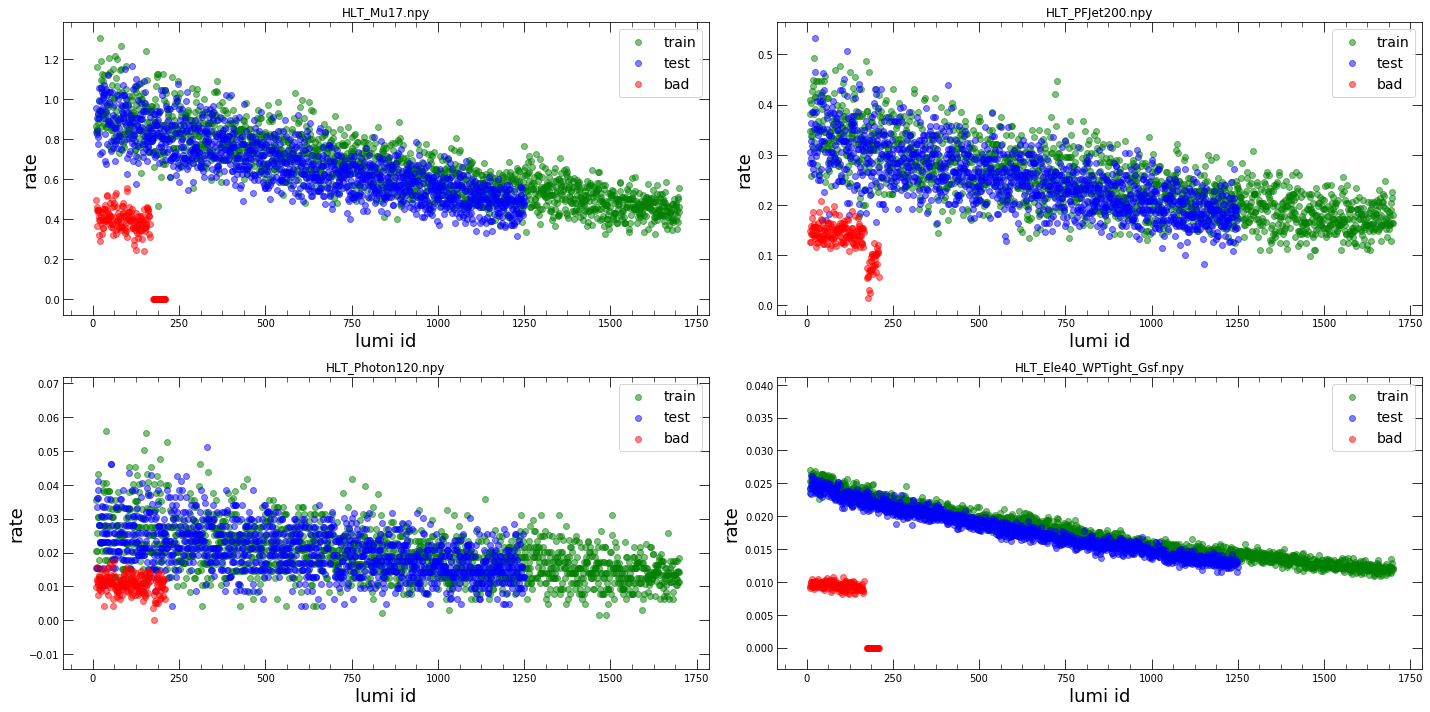

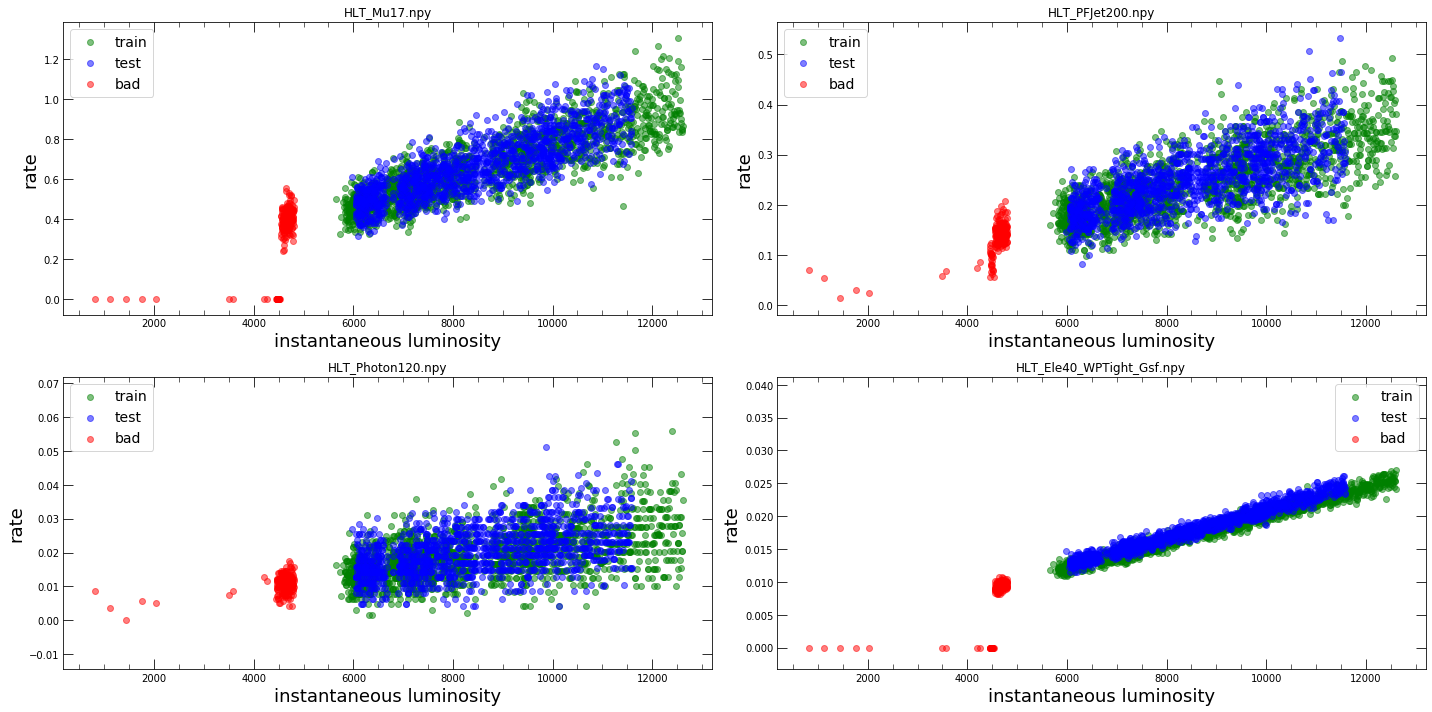

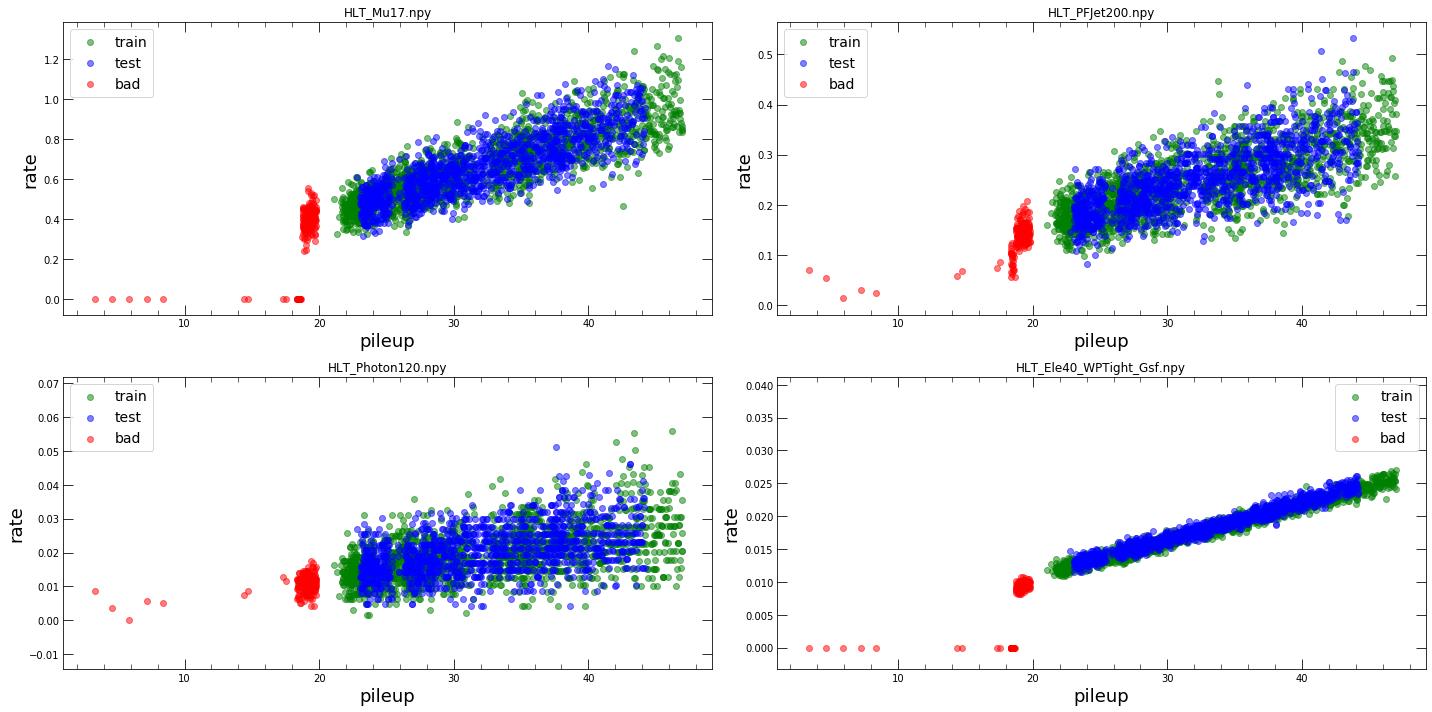

In [9]:
plots = [x_train,x_test,x_bad]
titles = ["train","test","bad"]

stuff = [[],[],[]]
lumi = [[],[],[]]
inst = [[],[],[]]
pileup = [[],[],[]]
for h in range(3):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    else:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r"]
    
plt.figure(figsize=[20,10])
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

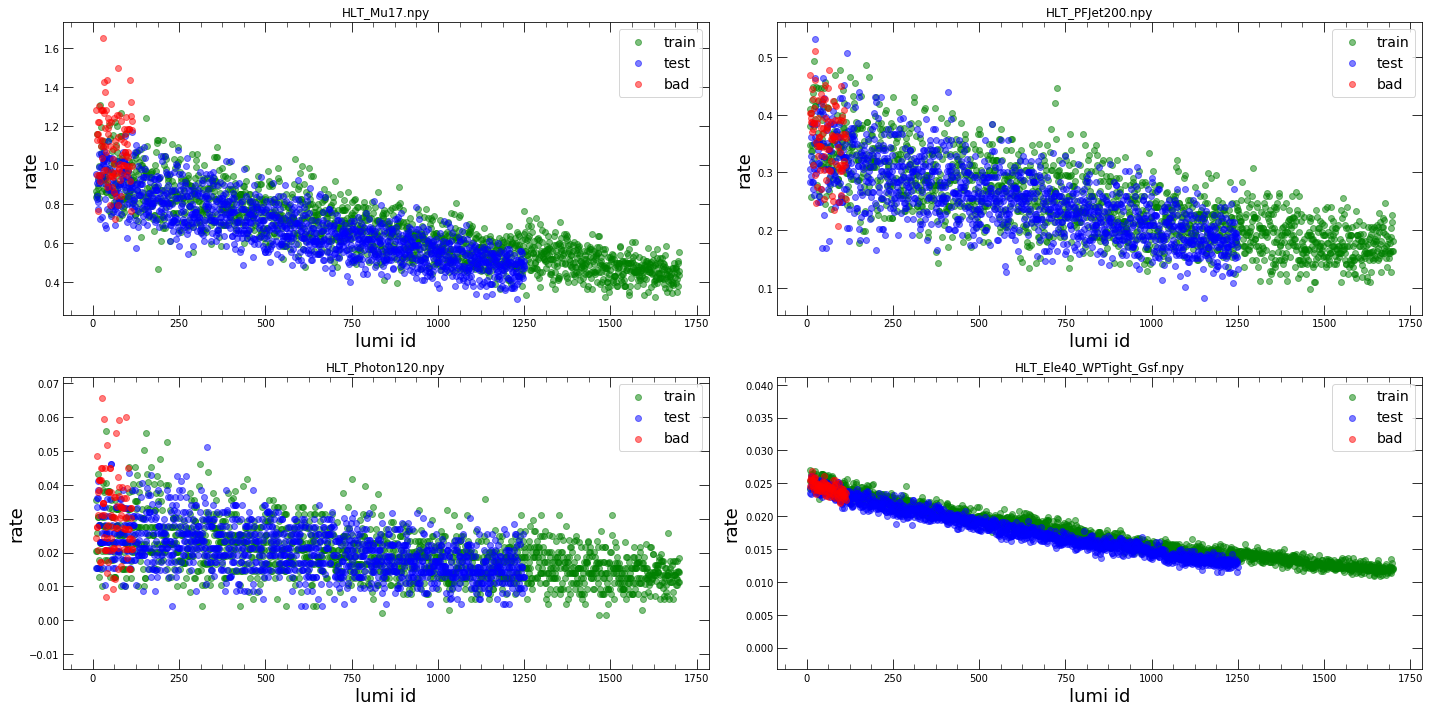

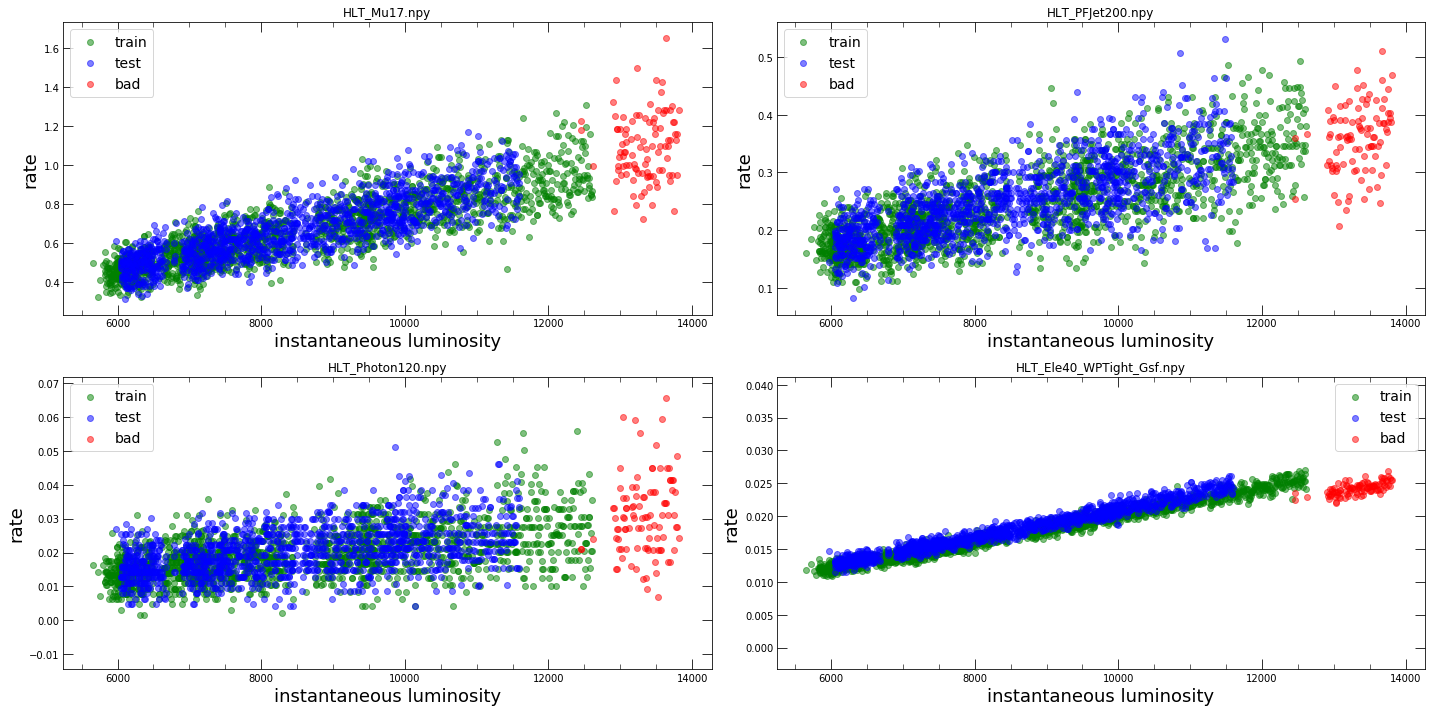

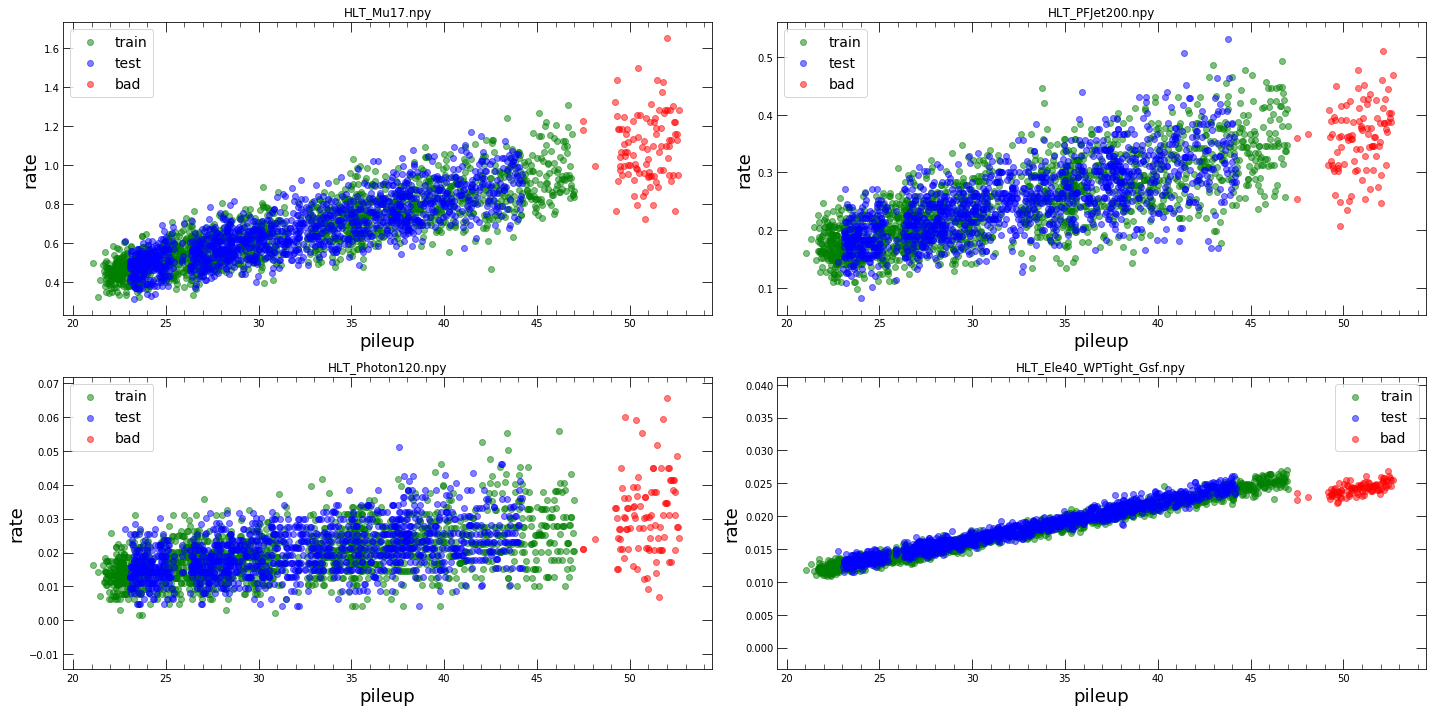

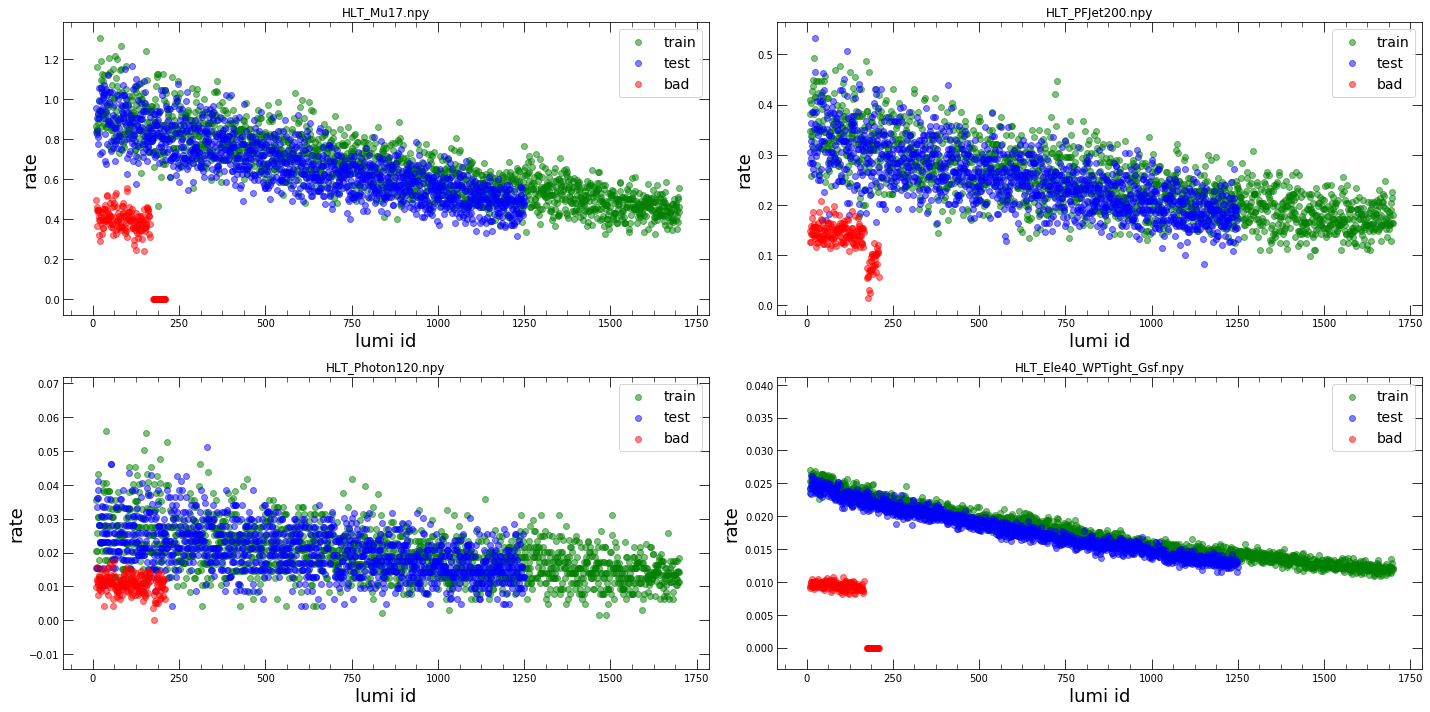

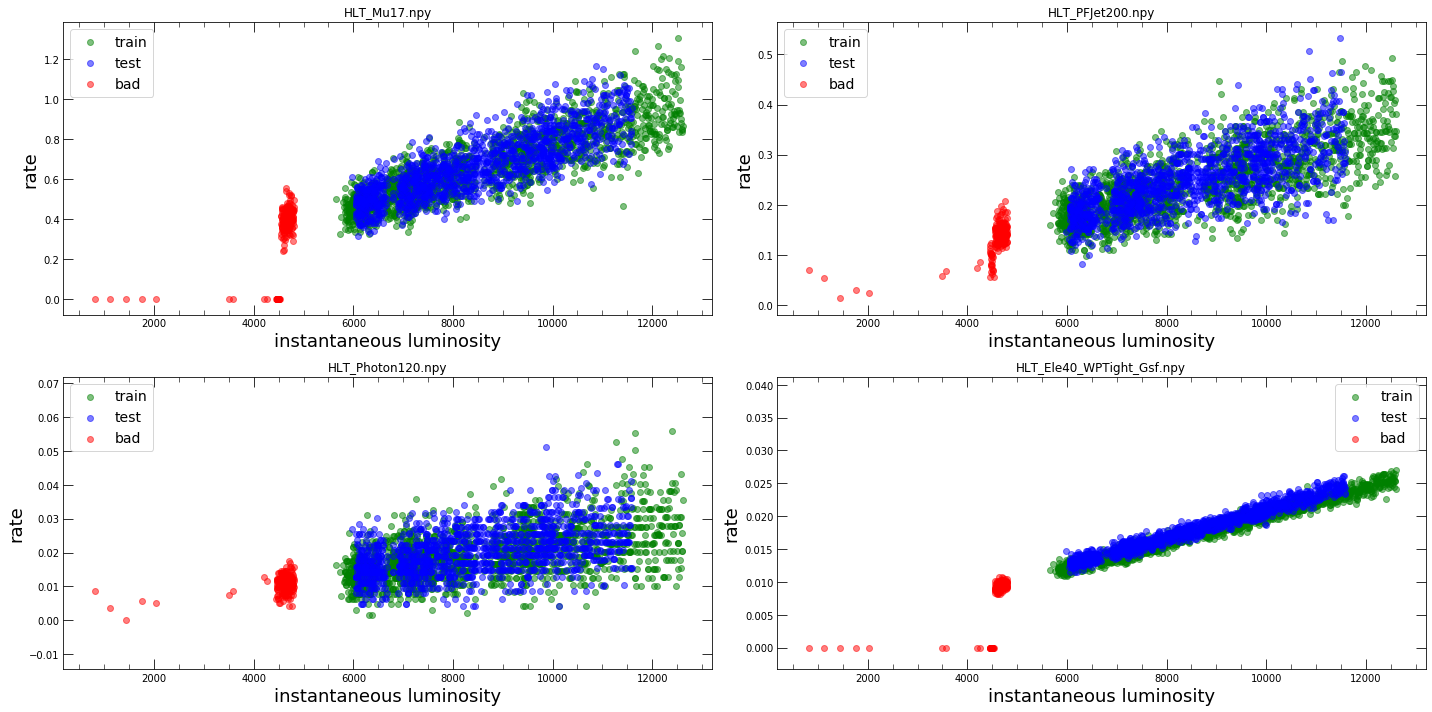

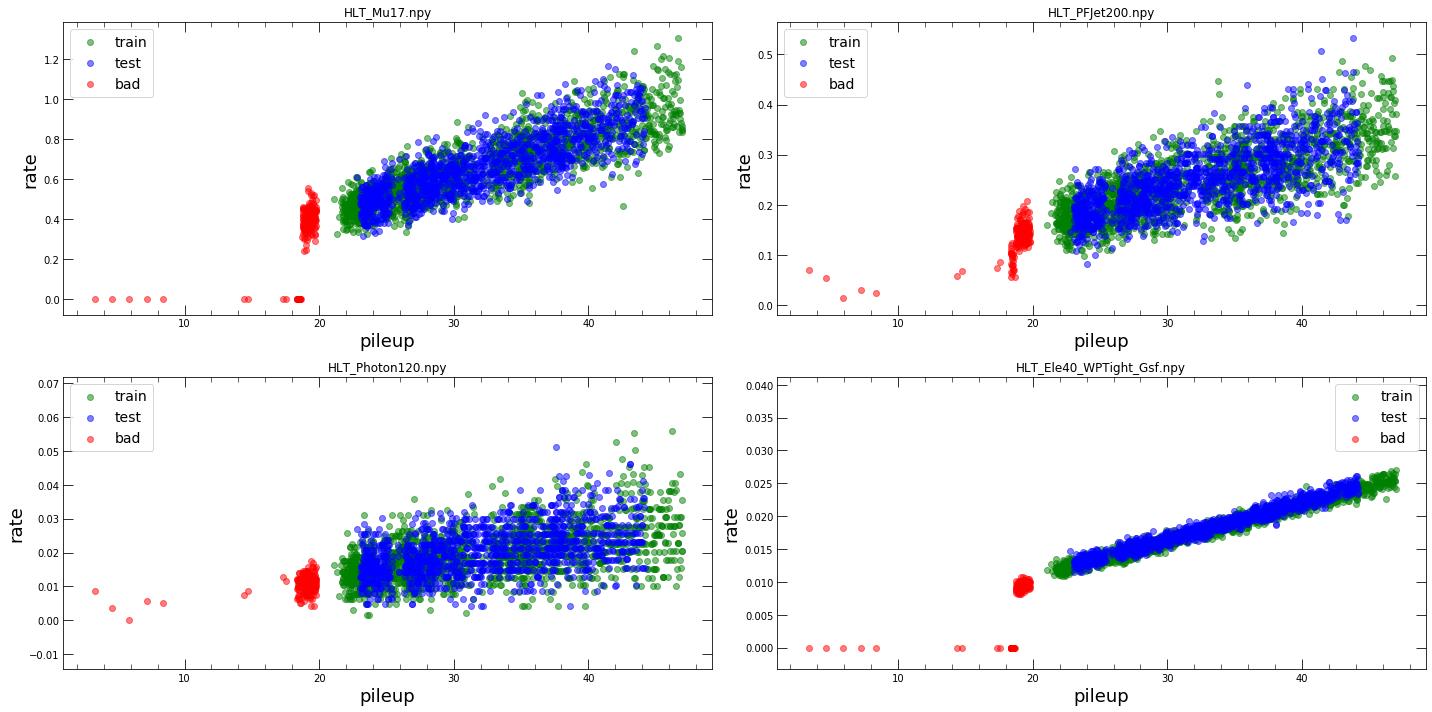

In [10]:
for run in bad_runs:
    plots = [x_train,x_test,x_bad]
    titles = ["train","test","bad"]

    stuff = [[],[],[]]
    lumi = [[],[],[]]
    inst = [[],[],[]]
    pileup = [[],[],[]]
    for h in range(3):
        if h == 0 or h == 1:
            lumi[h] = data[str(runs[h])]['lumiid']
            inst[h] = data[str(runs[h])]['instlumi']
            pileup[h] = data[str(runs[h])]['pileup']
            stuff[h] = data[str(runs[h])]['rates']
        else:
            lumi[h] = bad_data[str(run)]['lumiid']
            inst[h] = bad_data[str(run)]['instlumi']
            pileup[h] = bad_data[str(run)]['pileup']
            stuff[h] = bad_data[str(run)]['rates']

    labels = data['HLT'] 
    colors = ["g","b","r"]

    plt.figure(figsize=[20,10])
    for i in range(4):
        plt.subplot(2,2,i+1)
        for k in range(0,3):
            #print(len(i[k]),len(stuff[k][i]))
            plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
        plt.xlabel('lumi id')
        plt.ylabel('rate')
        plt.title(labels[i])
        plt.legend()

    plt.tight_layout()

    plt.figure(figsize=[20,10])

    for i in range(4):
        plt.subplot(2,2,i+1)
        for k in range(0,3):
            #print(len(inst[k][i]),len(stuff[k][i]))
            plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
        plt.xlabel('instantaneous luminosity')
        plt.ylabel('rate')
        plt.title(labels[i])
        plt.legend()

    plt.tight_layout()

    plt.figure(figsize=[20,10])

    for i in range(4):
        plt.subplot(2,2,i+1)
        for k in range(0,3):
            #print(len(lumi[k]),len(stuff[k][i]))
            plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
        plt.xlabel('pileup')
        plt.ylabel('rate')
        plt.title(labels[i])
        plt.legend()

    plt.tight_layout()

plt.show()

## Simple Autoencoder

In [12]:
model_name = "simplest_1"

In [13]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 4)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 15        
_________________________________________________________________
reconstructed (Dense)        (None, 4)                 16        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


Train on 1669 samples, validate on 1224 samples
Epoch 1/1000
 - 1s - loss: 7.2200 - val_loss: 7.1470
Epoch 2/1000
 - 0s - loss: 7.0624 - val_loss: 6.9684
Epoch 3/1000
 - 0s - loss: 6.8866 - val_loss: 6.7944
Epoch 4/1000
 - 0s - loss: 6.7126 - val_loss: 6.6187
Epoch 5/1000
 - 0s - loss: 6.5404 - val_loss: 6.4461
Epoch 6/1000
 - 0s - loss: 6.3685 - val_loss: 6.2771
Epoch 7/1000
 - 0s - loss: 6.2010 - val_loss: 6.1120
Epoch 8/1000
 - 0s - loss: 6.0390 - val_loss: 5.9508
Epoch 9/1000
 - 0s - loss: 5.8789 - val_loss: 5.7930
Epoch 10/1000
 - 0s - loss: 5.7227 - val_loss: 5.6391
Epoch 11/1000
 - 0s - loss: 5.5713 - val_loss: 5.4898
Epoch 12/1000
 - 0s - loss: 5.4235 - val_loss: 5.3438
Epoch 13/1000
 - 0s - loss: 5.2792 - val_loss: 5.2016
Epoch 14/1000
 - 0s - loss: 5.1389 - val_loss: 5.0633
Epoch 15/1000
 - 0s - loss: 5.0021 - val_loss: 4.9289
Epoch 16/1000
 - 0s - loss: 4.8697 - val_loss: 4.7990
Epoch 17/1000
 - 0s - loss: 4.7417 - val_loss: 4.6720
Epoch 18/1000
 - 0s - loss: 4.6156 - val_lo

Epoch 152/1000
 - 0s - loss: 0.3017 - val_loss: 0.2995
Epoch 153/1000
 - 0s - loss: 0.2972 - val_loss: 0.2951
Epoch 154/1000
 - 0s - loss: 0.2928 - val_loss: 0.2907
Epoch 155/1000
 - 0s - loss: 0.2885 - val_loss: 0.2864
Epoch 156/1000
 - 0s - loss: 0.2843 - val_loss: 0.2822
Epoch 157/1000
 - 0s - loss: 0.2801 - val_loss: 0.2780
Epoch 158/1000
 - 0s - loss: 0.2760 - val_loss: 0.2740
Epoch 159/1000
 - 0s - loss: 0.2720 - val_loss: 0.2700
Epoch 160/1000
 - 0s - loss: 0.2681 - val_loss: 0.2661
Epoch 161/1000
 - 0s - loss: 0.2641 - val_loss: 0.2623
Epoch 162/1000
 - 0s - loss: 0.2604 - val_loss: 0.2585
Epoch 163/1000
 - 0s - loss: 0.2567 - val_loss: 0.2548
Epoch 164/1000
 - 0s - loss: 0.2530 - val_loss: 0.2512
Epoch 165/1000
 - 0s - loss: 0.2494 - val_loss: 0.2476
Epoch 166/1000
 - 0s - loss: 0.2459 - val_loss: 0.2441
Epoch 167/1000
 - 0s - loss: 0.2424 - val_loss: 0.2407
Epoch 168/1000
 - 0s - loss: 0.2390 - val_loss: 0.2373
Epoch 169/1000
 - 0s - loss: 0.2357 - val_loss: 0.2340
Epoch 170/

Epoch 301/1000
 - 0s - loss: 0.0542 - val_loss: 0.0537
Epoch 302/1000
 - 0s - loss: 0.0537 - val_loss: 0.0532
Epoch 303/1000
 - 0s - loss: 0.0532 - val_loss: 0.0527
Epoch 304/1000
 - 0s - loss: 0.0528 - val_loss: 0.0523
Epoch 305/1000
 - 0s - loss: 0.0523 - val_loss: 0.0518
Epoch 306/1000
 - 0s - loss: 0.0518 - val_loss: 0.0513
Epoch 307/1000
 - 0s - loss: 0.0513 - val_loss: 0.0509
Epoch 308/1000
 - 0s - loss: 0.0509 - val_loss: 0.0504
Epoch 309/1000
 - 0s - loss: 0.0504 - val_loss: 0.0499
Epoch 310/1000
 - 0s - loss: 0.0500 - val_loss: 0.0495
Epoch 311/1000
 - 0s - loss: 0.0495 - val_loss: 0.0491
Epoch 312/1000
 - 0s - loss: 0.0491 - val_loss: 0.0486
Epoch 313/1000
 - 0s - loss: 0.0487 - val_loss: 0.0482
Epoch 314/1000
 - 0s - loss: 0.0482 - val_loss: 0.0478
Epoch 315/1000
 - 0s - loss: 0.0478 - val_loss: 0.0473
Epoch 316/1000
 - 0s - loss: 0.0474 - val_loss: 0.0469
Epoch 317/1000
 - 0s - loss: 0.0470 - val_loss: 0.0465
Epoch 318/1000
 - 0s - loss: 0.0465 - val_loss: 0.0461
Epoch 319/

Epoch 450/1000
 - 0s - loss: 0.0160 - val_loss: 0.0158
Epoch 451/1000
 - 0s - loss: 0.0159 - val_loss: 0.0157
Epoch 452/1000
 - 0s - loss: 0.0158 - val_loss: 0.0155
Epoch 453/1000
 - 0s - loss: 0.0157 - val_loss: 0.0154
Epoch 454/1000
 - 0s - loss: 0.0156 - val_loss: 0.0153
Epoch 455/1000
 - 0s - loss: 0.0155 - val_loss: 0.0152
Epoch 456/1000
 - 0s - loss: 0.0153 - val_loss: 0.0151
Epoch 457/1000
 - 0s - loss: 0.0152 - val_loss: 0.0150
Epoch 458/1000
 - 0s - loss: 0.0151 - val_loss: 0.0149
Epoch 459/1000
 - 0s - loss: 0.0150 - val_loss: 0.0147
Epoch 460/1000
 - 0s - loss: 0.0149 - val_loss: 0.0146
Epoch 461/1000
 - 0s - loss: 0.0148 - val_loss: 0.0145
Epoch 462/1000
 - 0s - loss: 0.0147 - val_loss: 0.0144
Epoch 463/1000
 - 0s - loss: 0.0146 - val_loss: 0.0143
Epoch 464/1000
 - 0s - loss: 0.0145 - val_loss: 0.0142
Epoch 465/1000
 - 0s - loss: 0.0144 - val_loss: 0.0141
Epoch 466/1000
 - 0s - loss: 0.0143 - val_loss: 0.0140
Epoch 467/1000
 - 0s - loss: 0.0142 - val_loss: 0.0139
Epoch 468/

Epoch 599/1000
 - 0s - loss: 0.0058 - val_loss: 0.0056
Epoch 600/1000
 - 0s - loss: 0.0057 - val_loss: 0.0056
Epoch 601/1000
 - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 602/1000
 - 0s - loss: 0.0057 - val_loss: 0.0055
Epoch 603/1000
 - 0s - loss: 0.0056 - val_loss: 0.0055
Epoch 604/1000
 - 0s - loss: 0.0056 - val_loss: 0.0054
Epoch 605/1000
 - 0s - loss: 0.0056 - val_loss: 0.0054
Epoch 606/1000
 - 0s - loss: 0.0055 - val_loss: 0.0054
Epoch 607/1000
 - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 608/1000
 - 0s - loss: 0.0055 - val_loss: 0.0053
Epoch 609/1000
 - 0s - loss: 0.0054 - val_loss: 0.0053
Epoch 610/1000
 - 0s - loss: 0.0054 - val_loss: 0.0052
Epoch 611/1000
 - 0s - loss: 0.0054 - val_loss: 0.0052
Epoch 612/1000
 - 0s - loss: 0.0053 - val_loss: 0.0052
Epoch 613/1000
 - 0s - loss: 0.0053 - val_loss: 0.0051
Epoch 614/1000
 - 0s - loss: 0.0053 - val_loss: 0.0051
Epoch 615/1000
 - 0s - loss: 0.0052 - val_loss: 0.0051
Epoch 616/1000
 - 0s - loss: 0.0052 - val_loss: 0.0050
Epoch 617/

Epoch 748/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 749/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 750/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 751/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 752/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 753/1000
 - 0s - loss: 0.0025 - val_loss: 0.0024
Epoch 754/1000
 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 755/1000
 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 756/1000
 - 0s - loss: 0.0025 - val_loss: 0.0023
Epoch 757/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 758/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 759/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 760/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 761/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 762/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 763/1000
 - 0s - loss: 0.0024 - val_loss: 0.0023
Epoch 764/1000
 - 0s - loss: 0.0024 - val_loss: 0.0022
Epoch 765/1000
 - 0s - loss: 0.0024 - val_loss: 0.0022
Epoch 766/

Epoch 897/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 898/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 899/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 900/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 901/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 902/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 903/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 904/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 905/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 906/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 907/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 908/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 909/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 910/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 911/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 912/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 913/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 914/1000
 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 915/

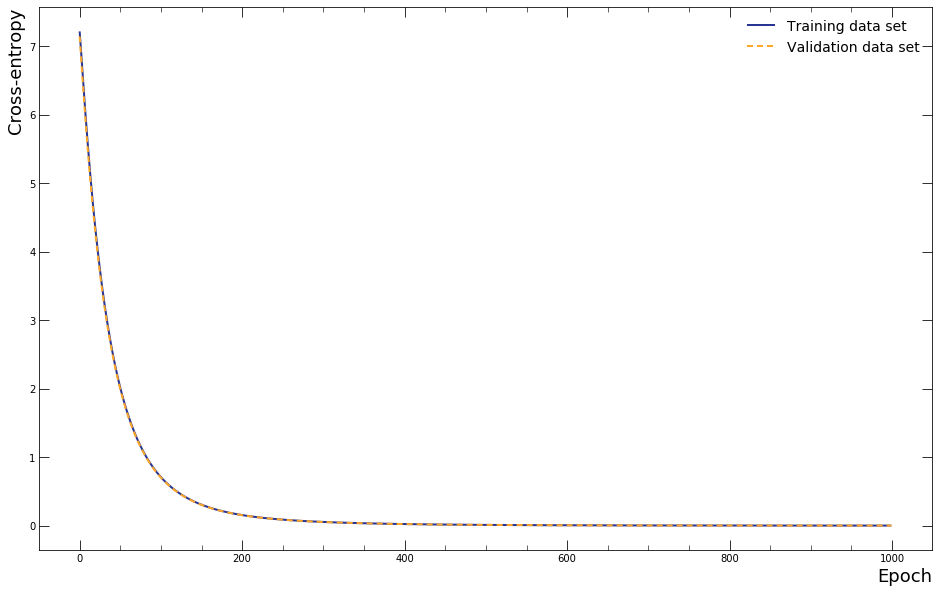

In [14]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

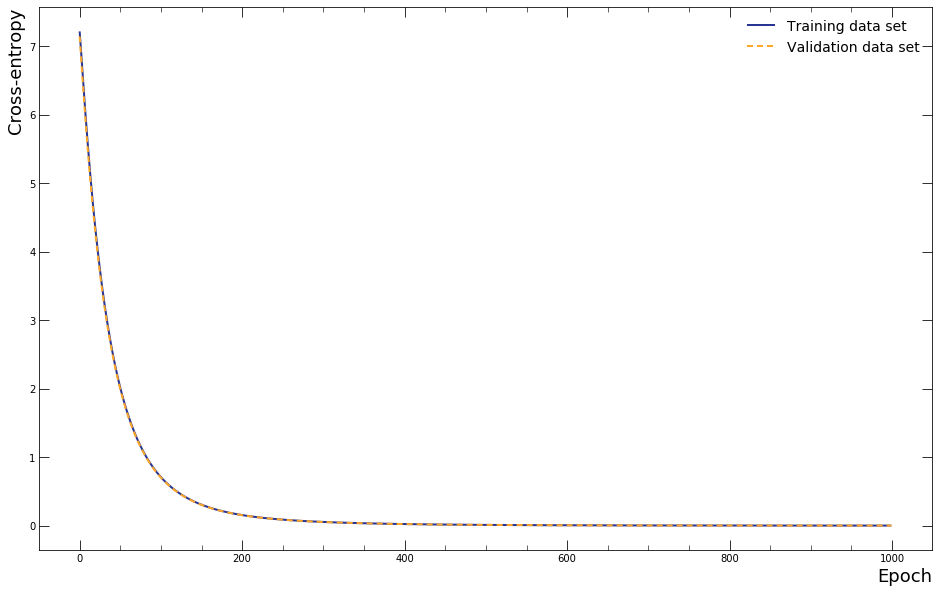

In [15]:
plot_loss(history)

## Training Set

In [16]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_train_new = []
lumi_new = []
lumi = data[str(runs[0])]['lumiid'] 

for l in range(len(x_train)):
    if not 0 in x_train[l]:
        x_train_new.append(x_train[l])
        for i in range(WINDOW):
            lumi_new.append(lumi[l+i])
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [17]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

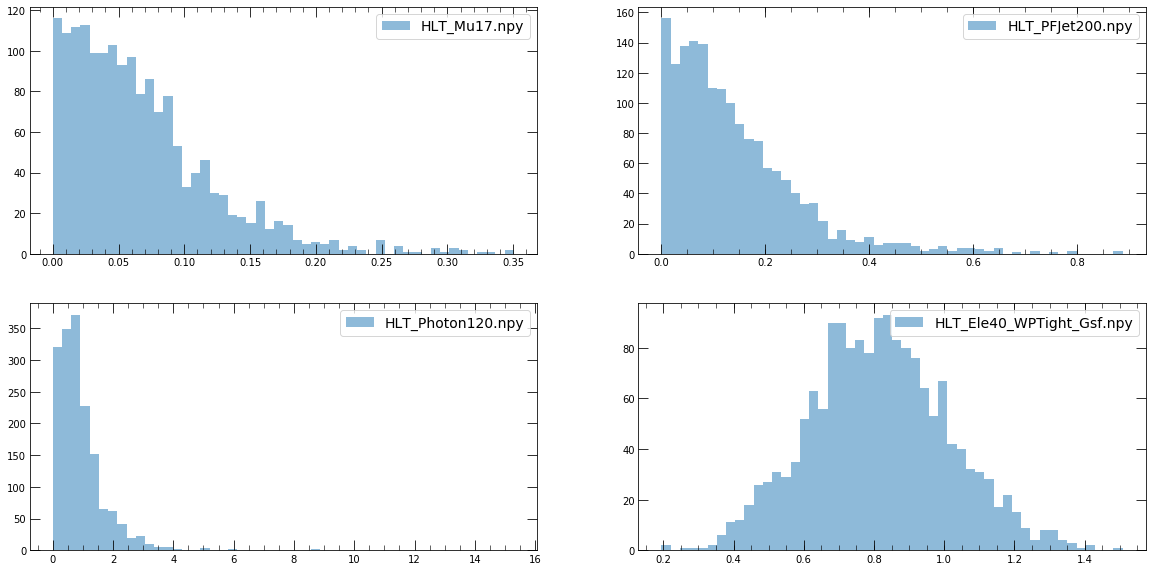

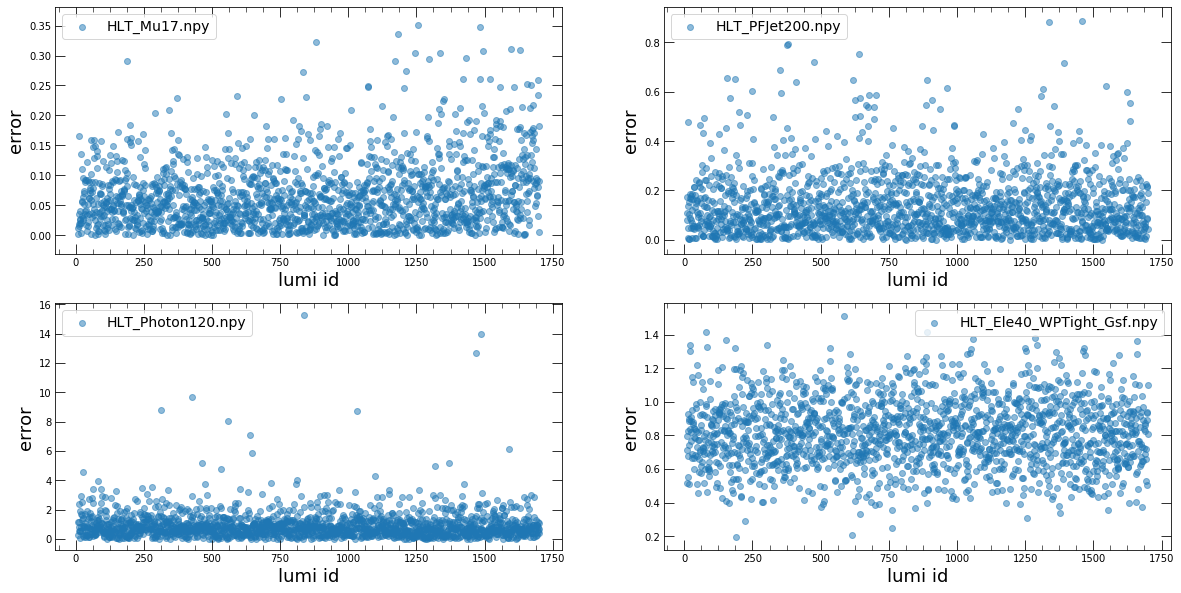

In [18]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

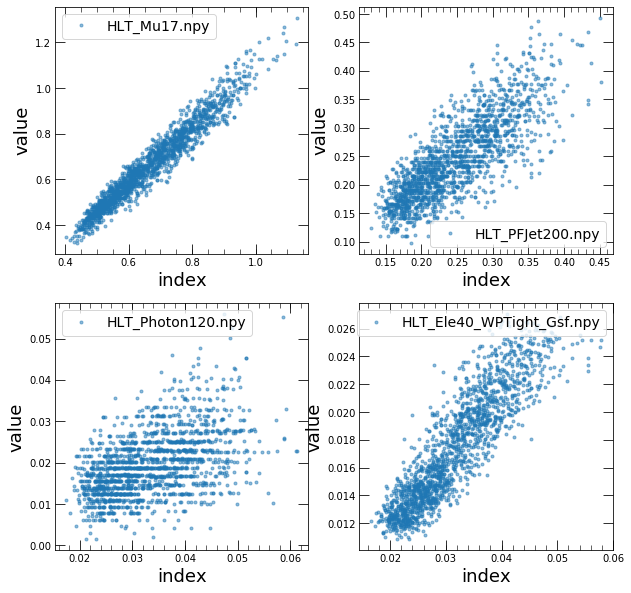

In [19]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## MSE of each sample

In [22]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(x_train))

means = []
error = []
for s in range(len(x_train)):
    mean = np.mean(x_train[s])
    means.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error.append(mse)
    
lumi = data[str(runs[0])]['lumiid'] 

In [23]:
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

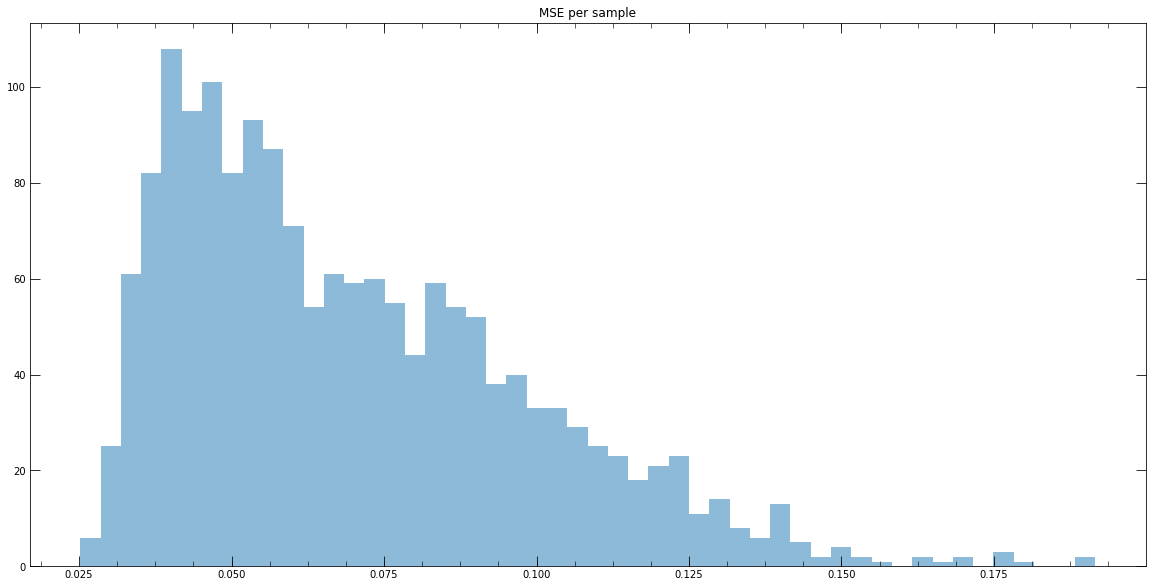

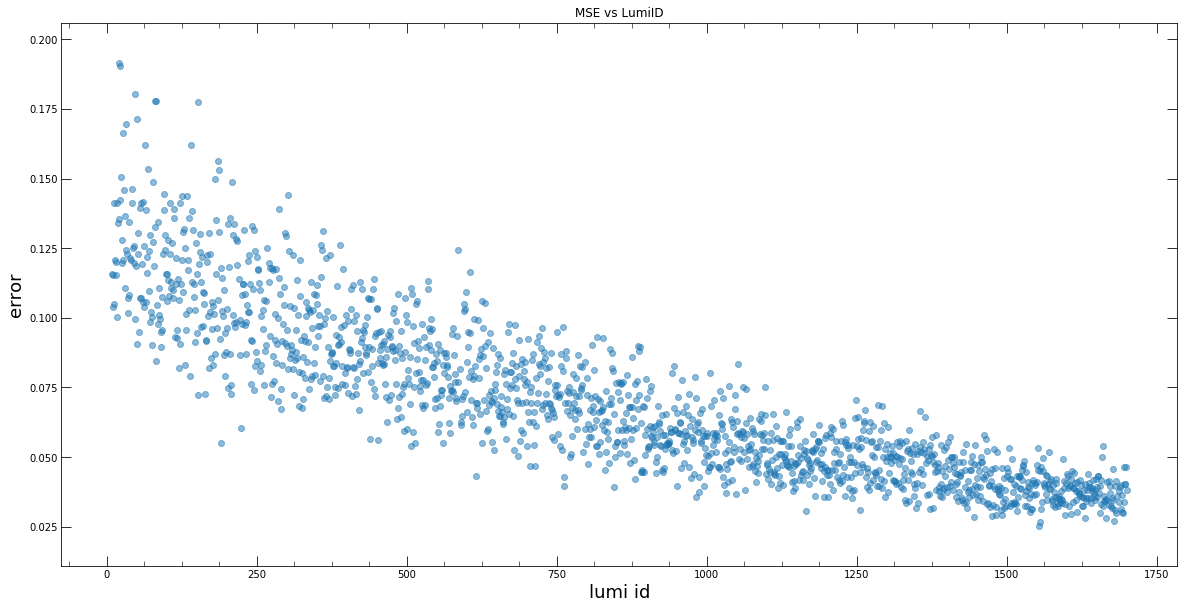

In [25]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

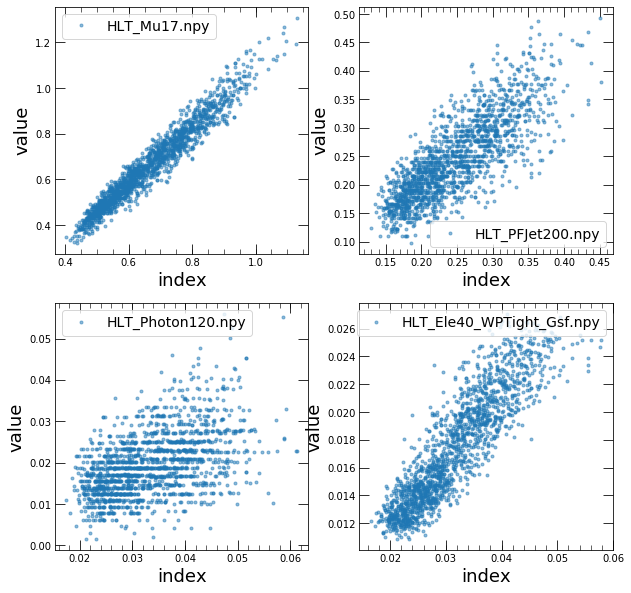

In [26]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [27]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [28]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    print(len(error_reformat[0]))
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

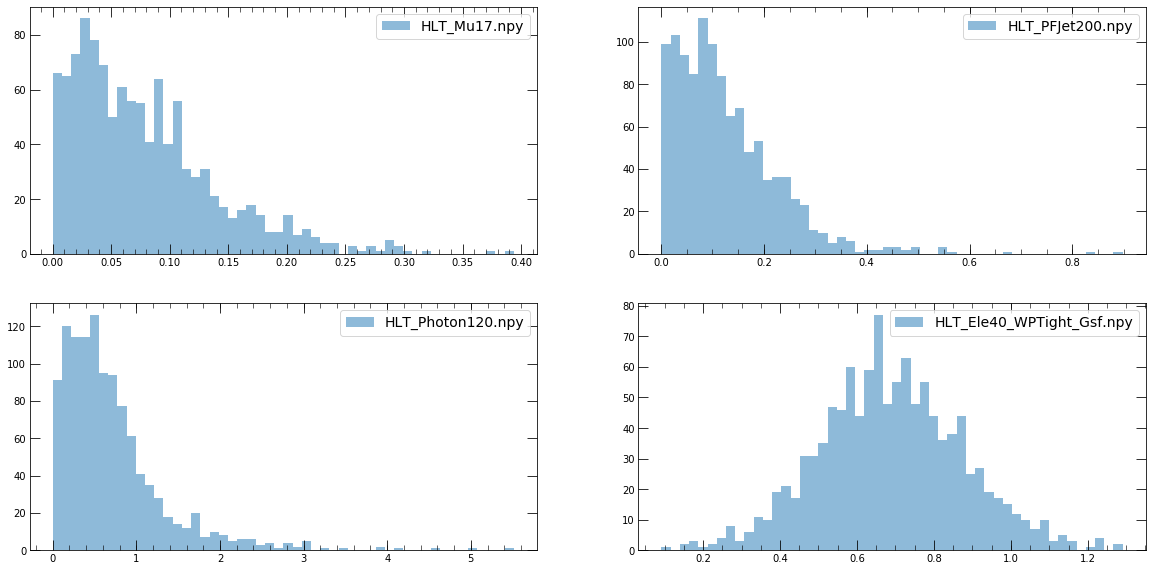

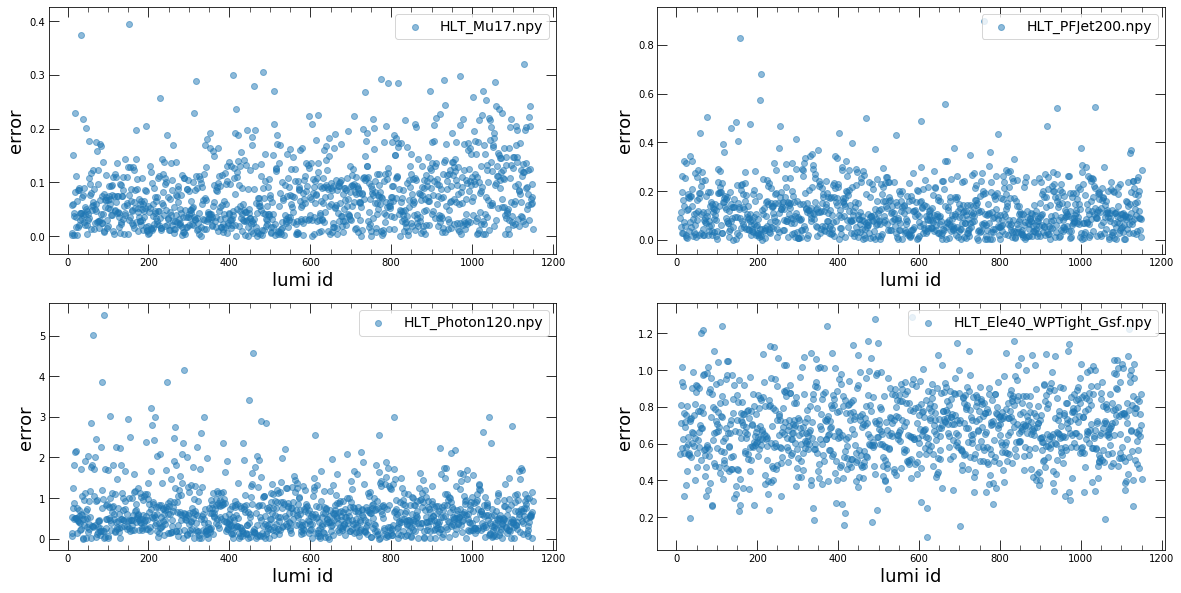

In [29]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

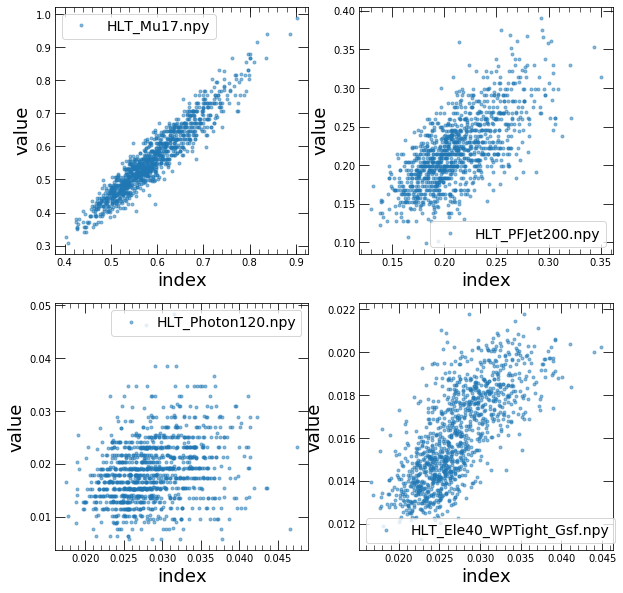

In [30]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## MSE of each sample

In [36]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(x_test))

means = []
error = []
for s in range(len(x_test)):
    mean = np.mean(x_test[s])
    means.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error.append(mse)
    
lumi = data[str(runs[2])]['lumiid'] 

In [37]:
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train_new[i][WINDOW*j])

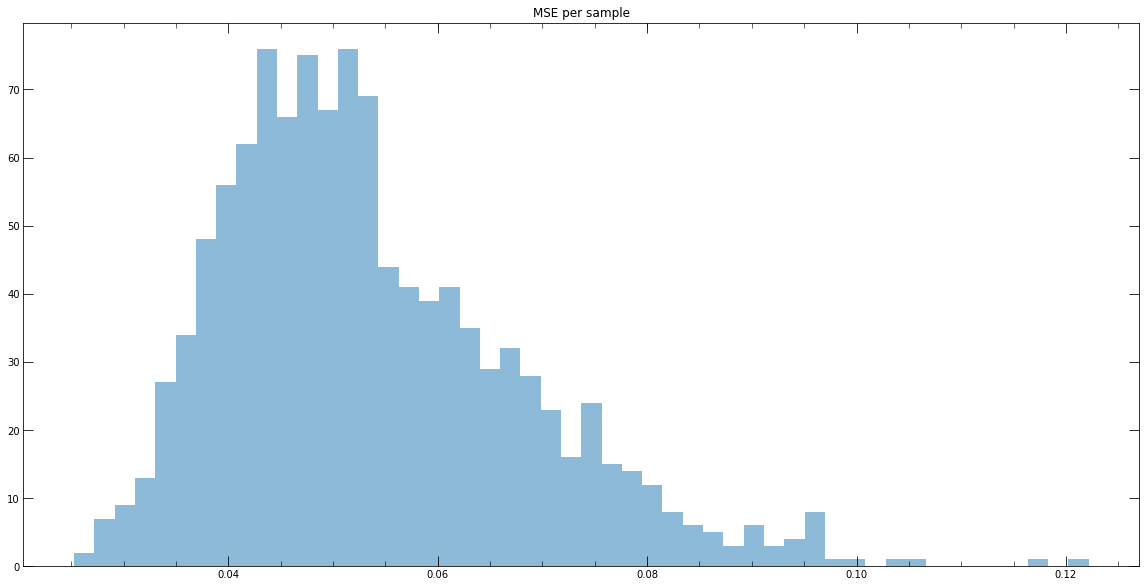

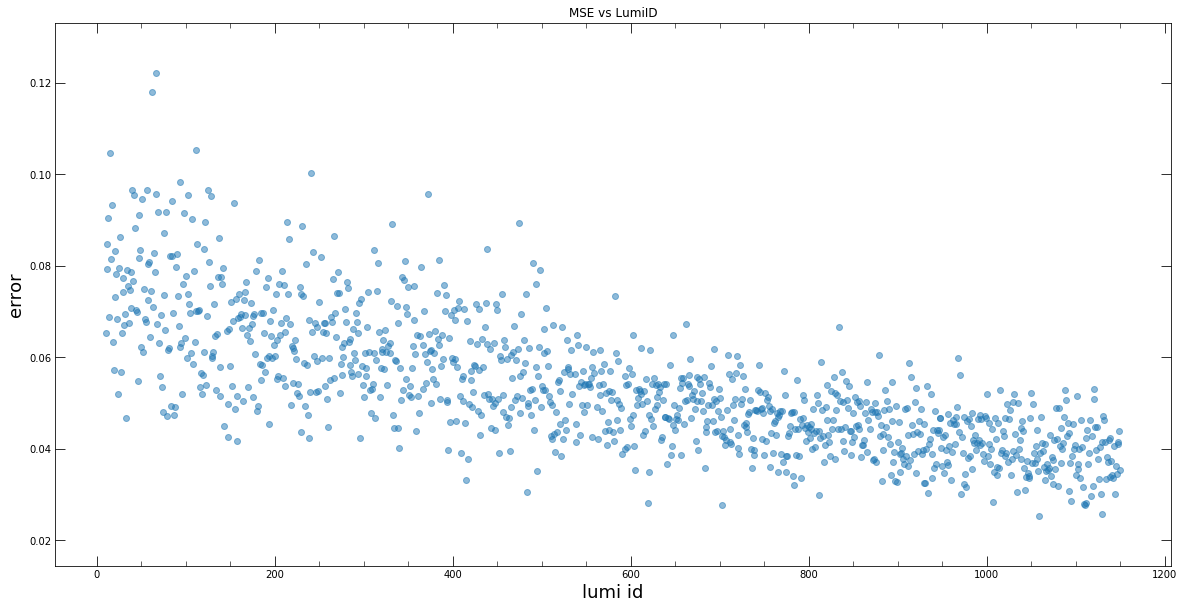

In [38]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

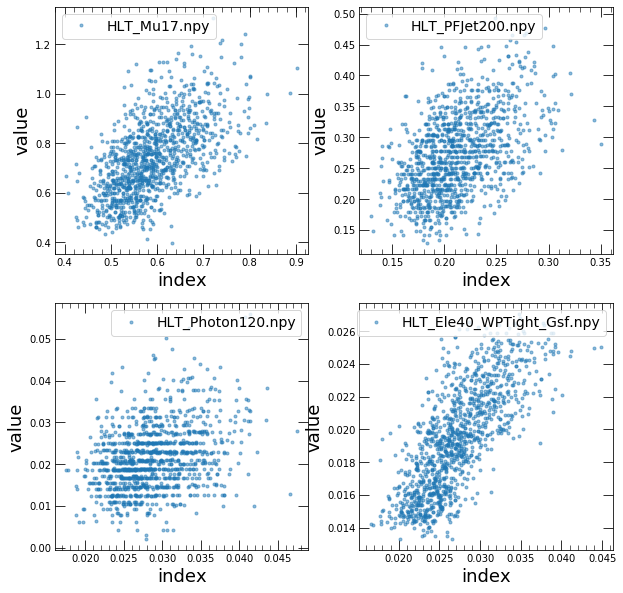

In [40]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Fake Bad Data

In [41]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [42]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [43]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129 1129


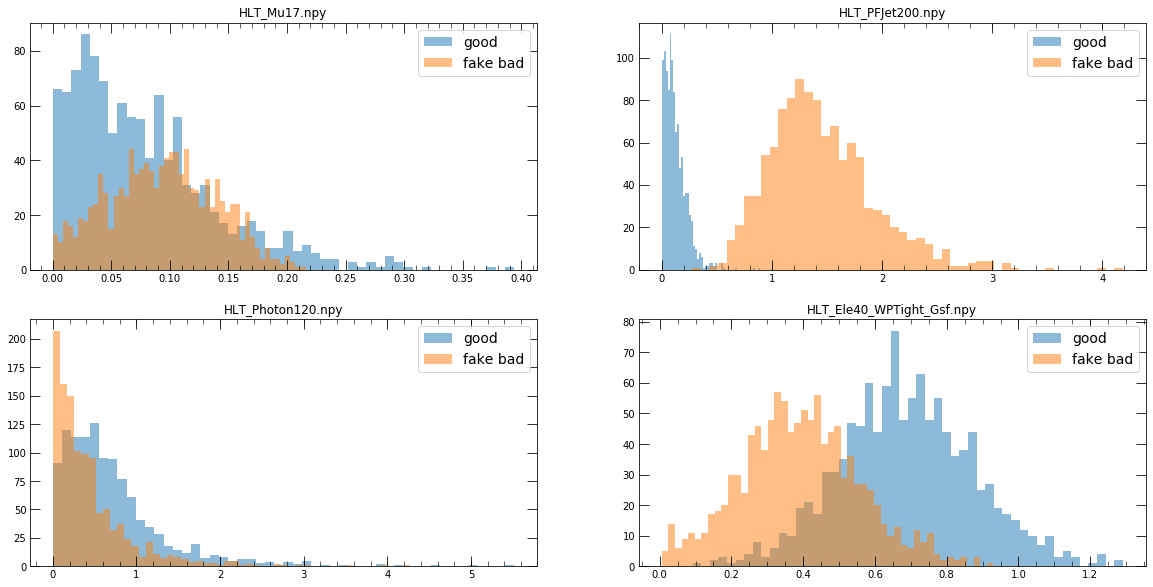

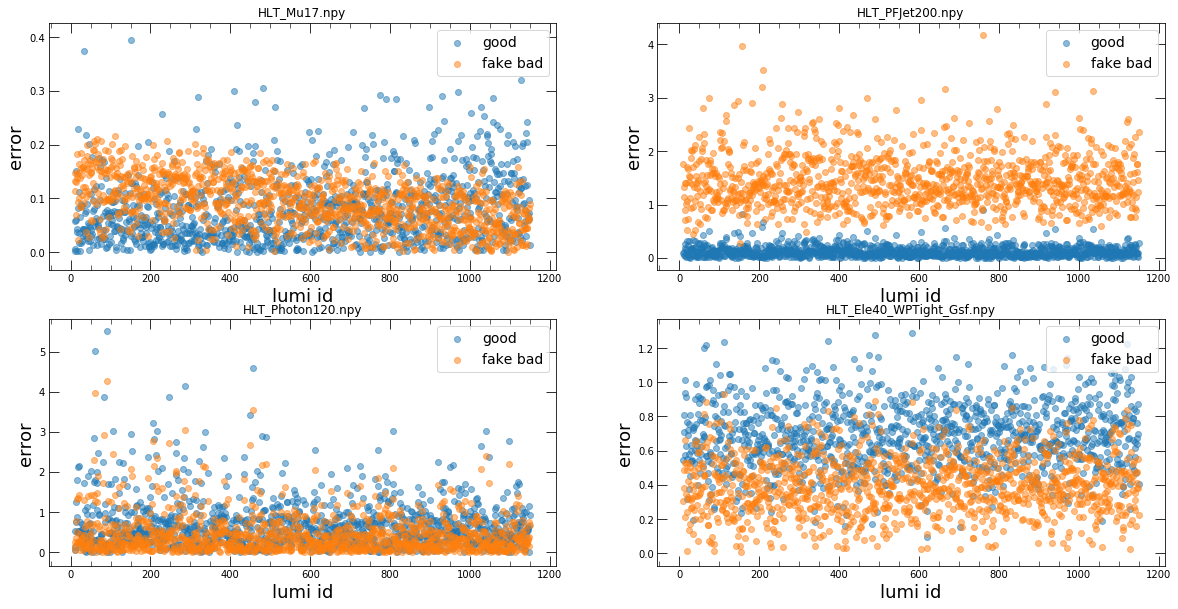

In [44]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

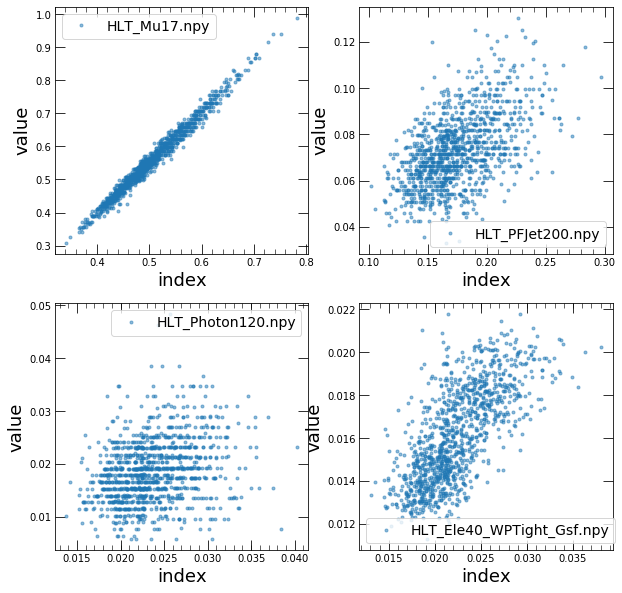

In [45]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

## MSE of each sample

In [46]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

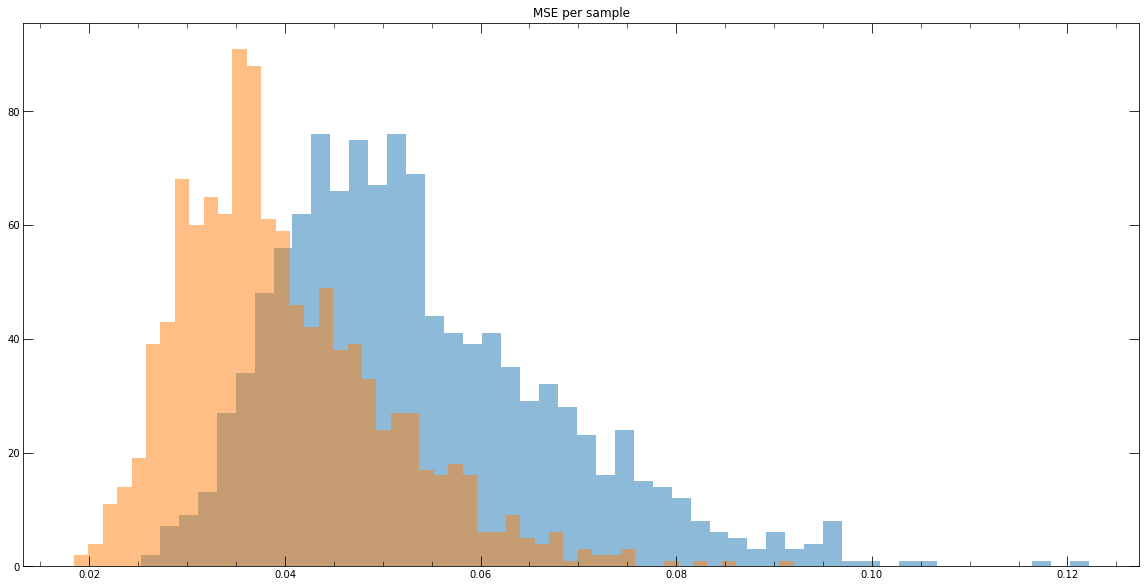

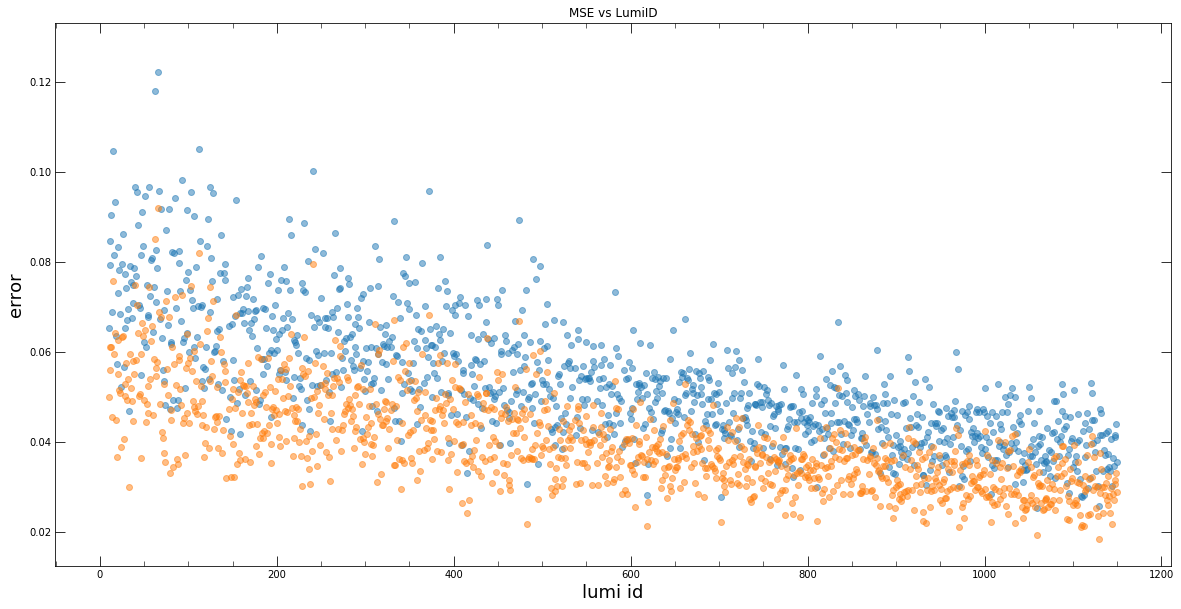

In [47]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='good',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='good',alpha=.5)
plt.scatter(lumi,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

## Fake Bad Data - ALL

In [49]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [50]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [51]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1129 1129


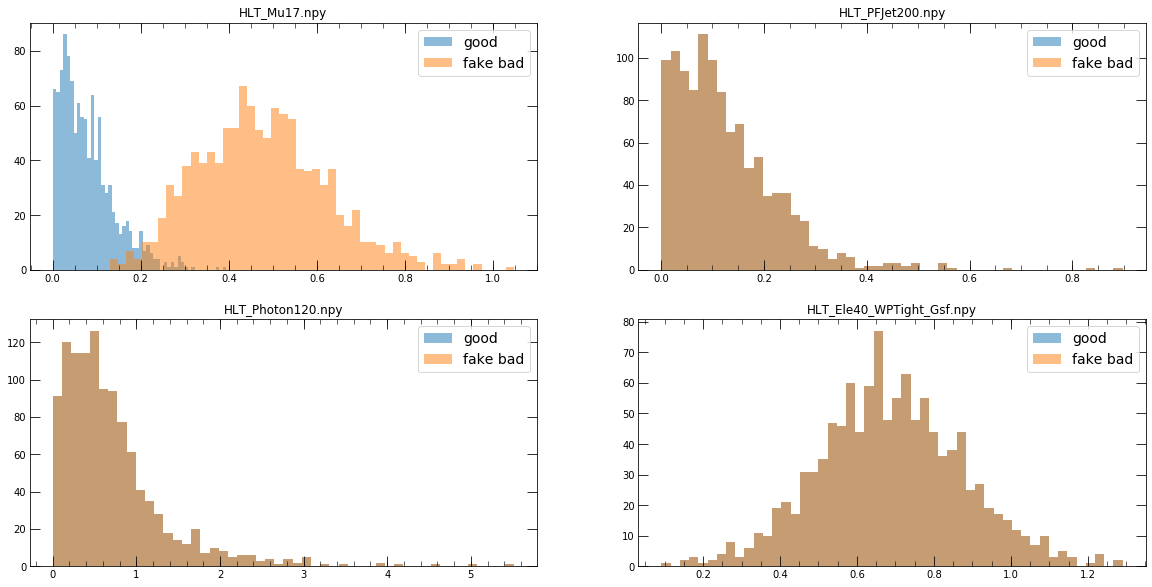

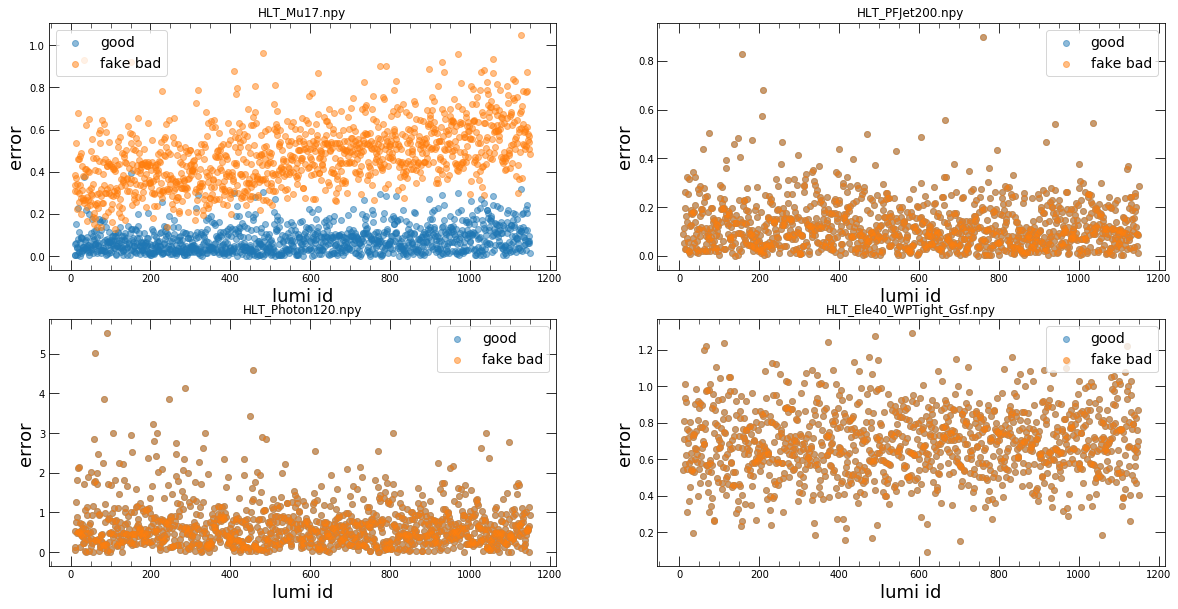

In [52]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

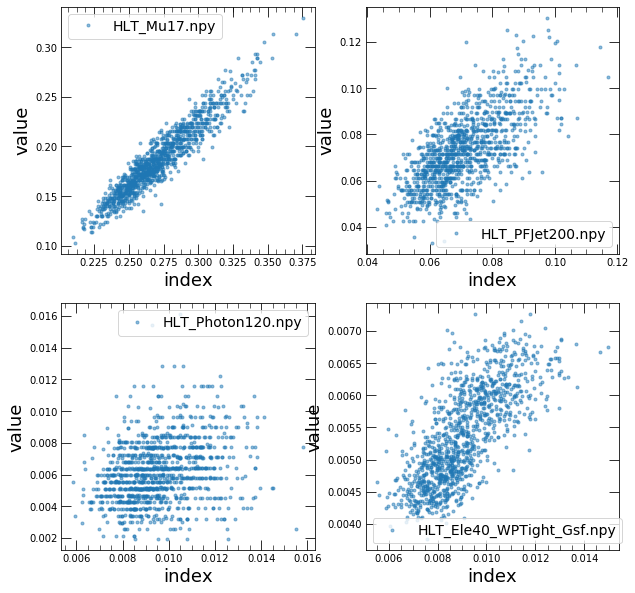

In [53]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## MSE of each sample

In [54]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

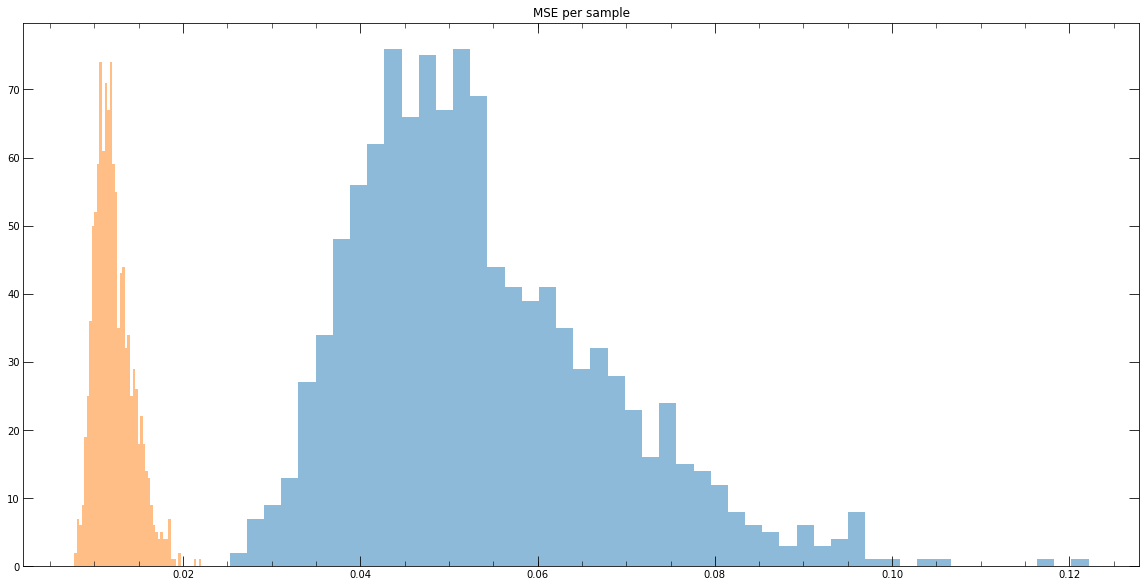

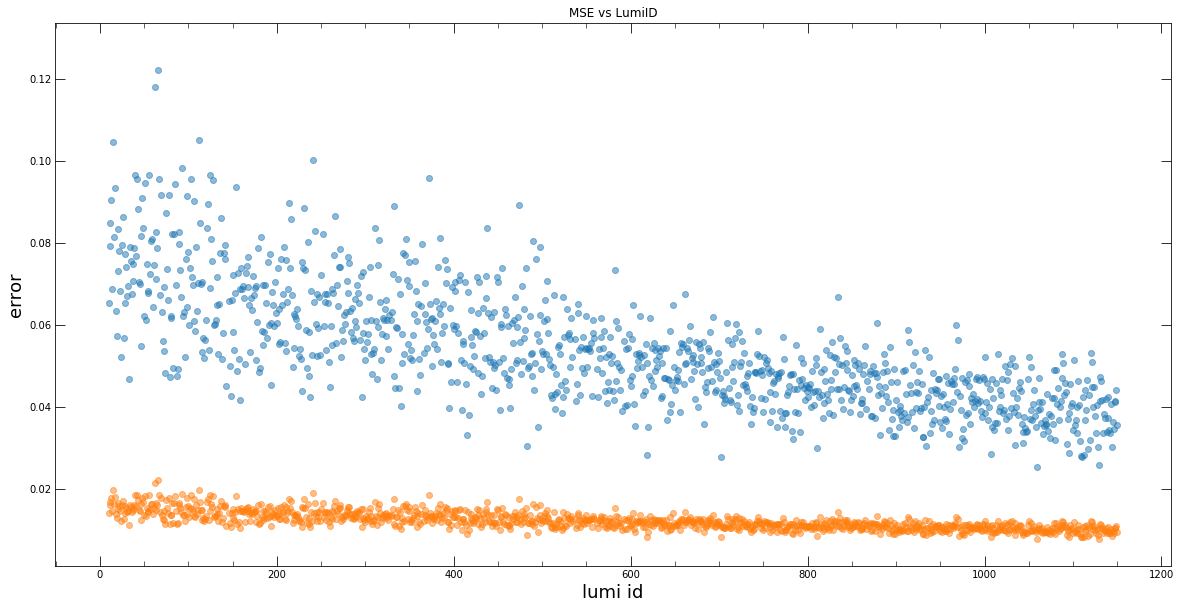

In [55]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='good',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='good',alpha=.5)
plt.scatter(lumi,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

## Real Bad Data

In [64]:
bad_runs = [301480]

with open('unscaled_bad_data_WINDOW1.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [65]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [66]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


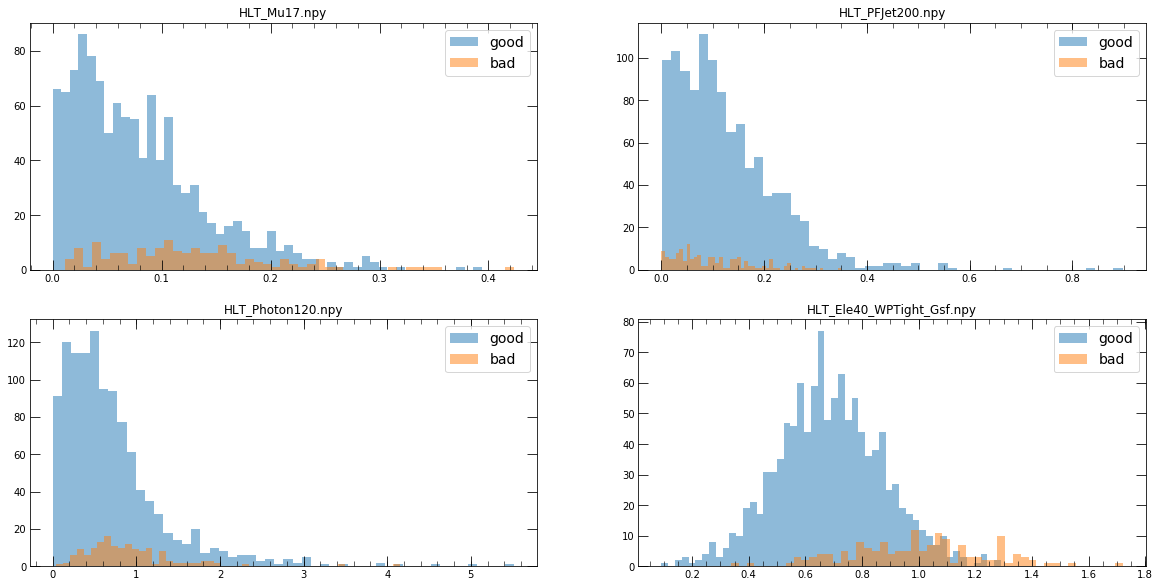

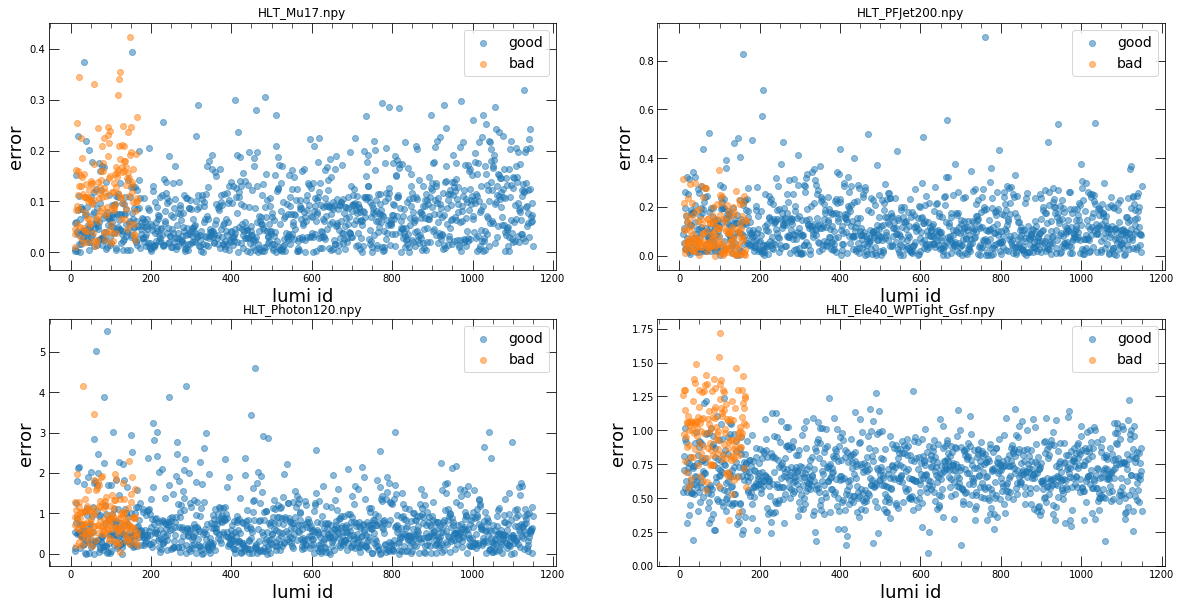

In [67]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

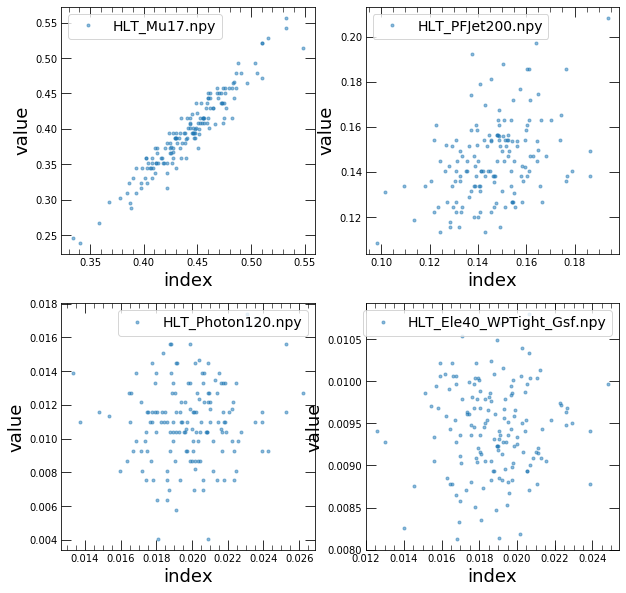

In [68]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## MSE of each sample

In [69]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

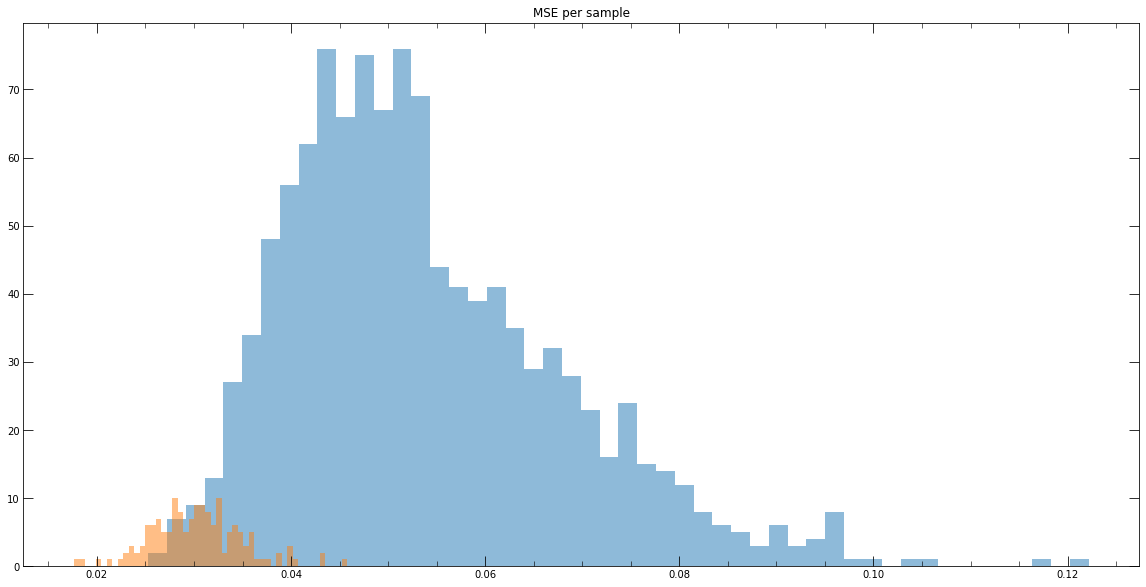

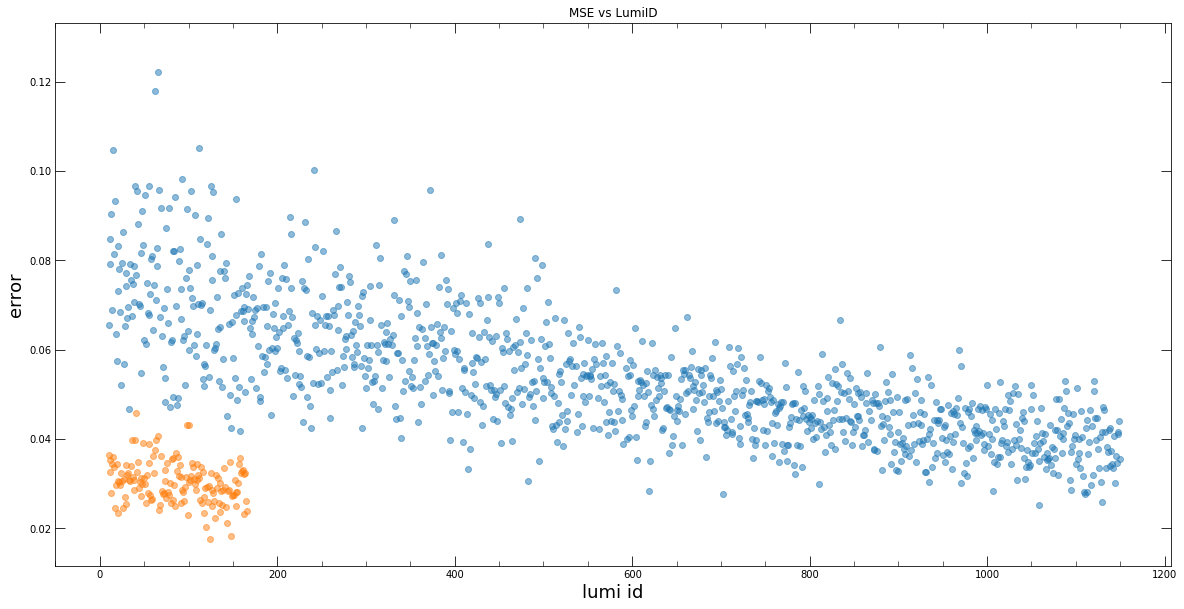

In [70]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='good',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='good',alpha=.5)
plt.scatter(lumi_new,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()

## Real Bad Data

In [71]:
bad_runs = [305588]

with open('unscaled_bad_data_WINDOW1.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [72]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
    
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [73]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


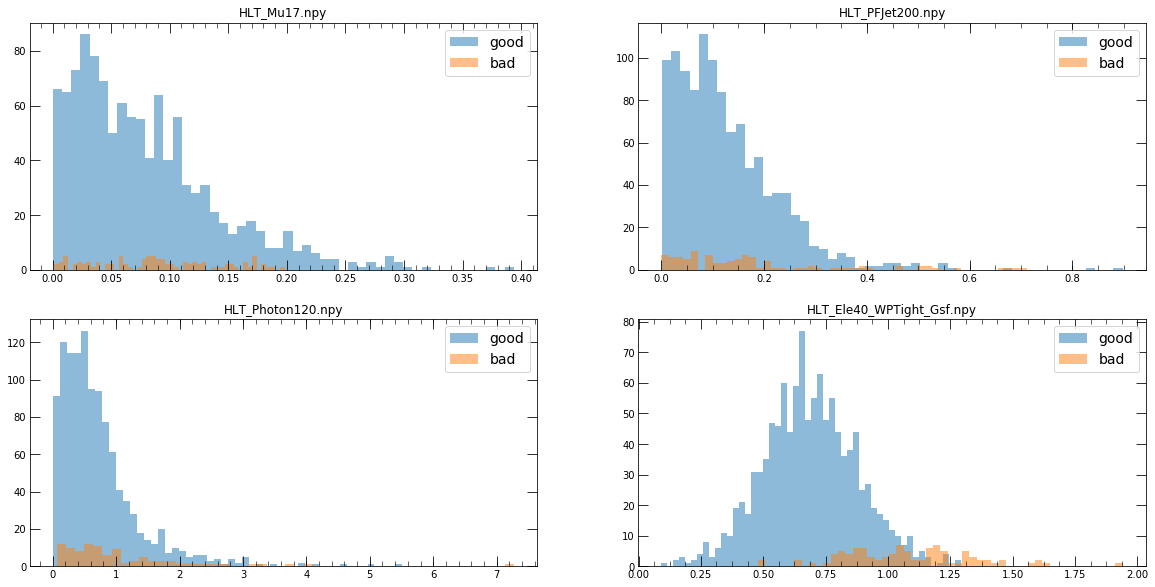

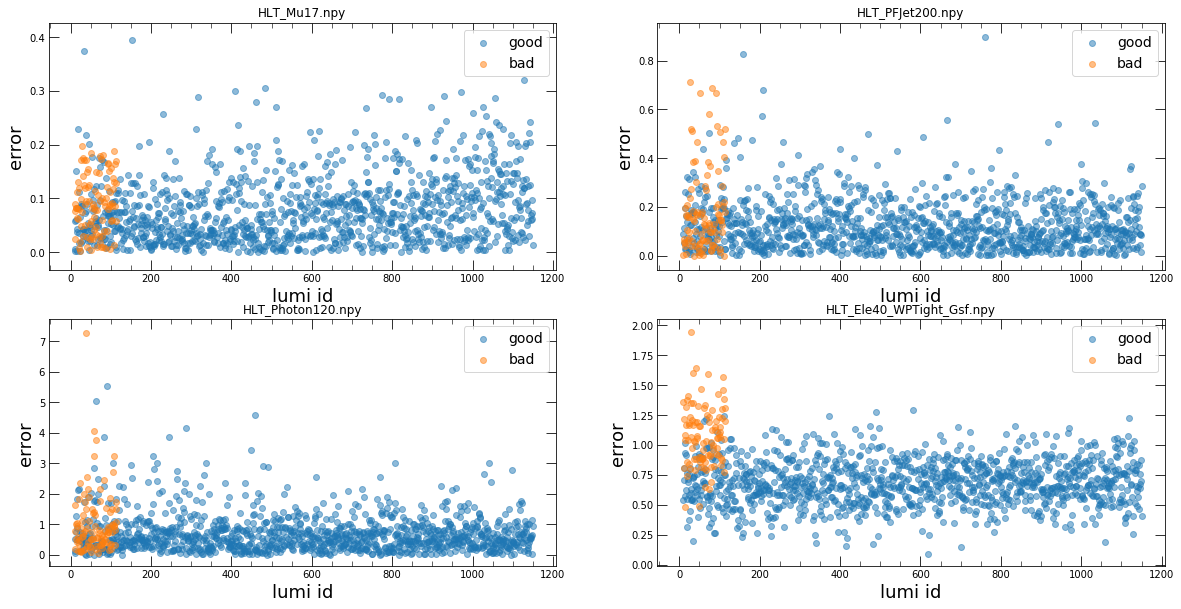

In [74]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

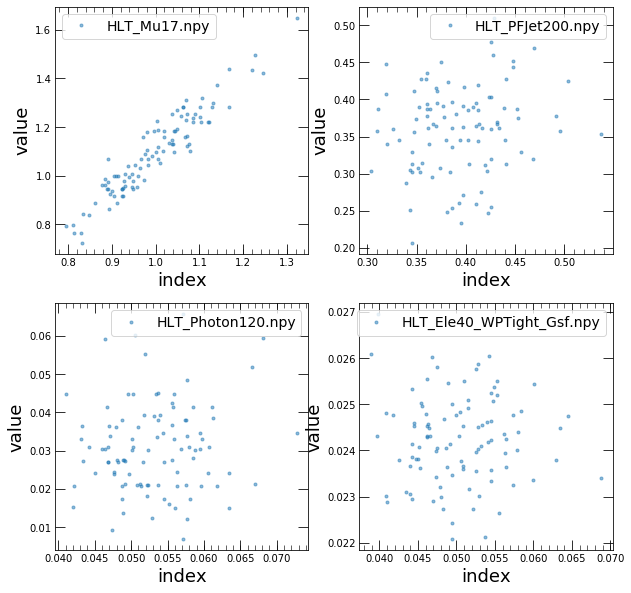

In [75]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## MSE of each sample

In [76]:
# Generate predictions

model = load_model("%s.h5" % (model_name))   
reconstructed = model.predict(np.array(bad_new))

means_bad = []
error_bad = []
for s in range(len(bad_new)):
    mean = np.mean(bad_new[s])
    means_bad.append(mean)
    
    mse = 0
    for r in range(len(reconstructed[s])):
        mse += (reconstructed[s][r]-mean)**2
        
    mse = mse/len(reconstructed[s])
    error_bad.append(mse)

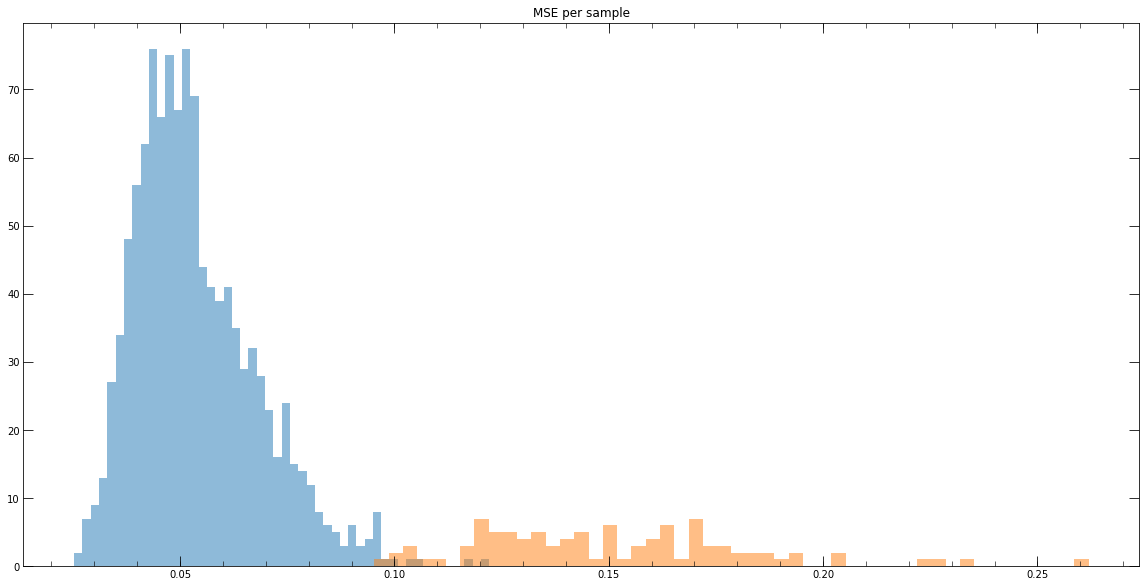

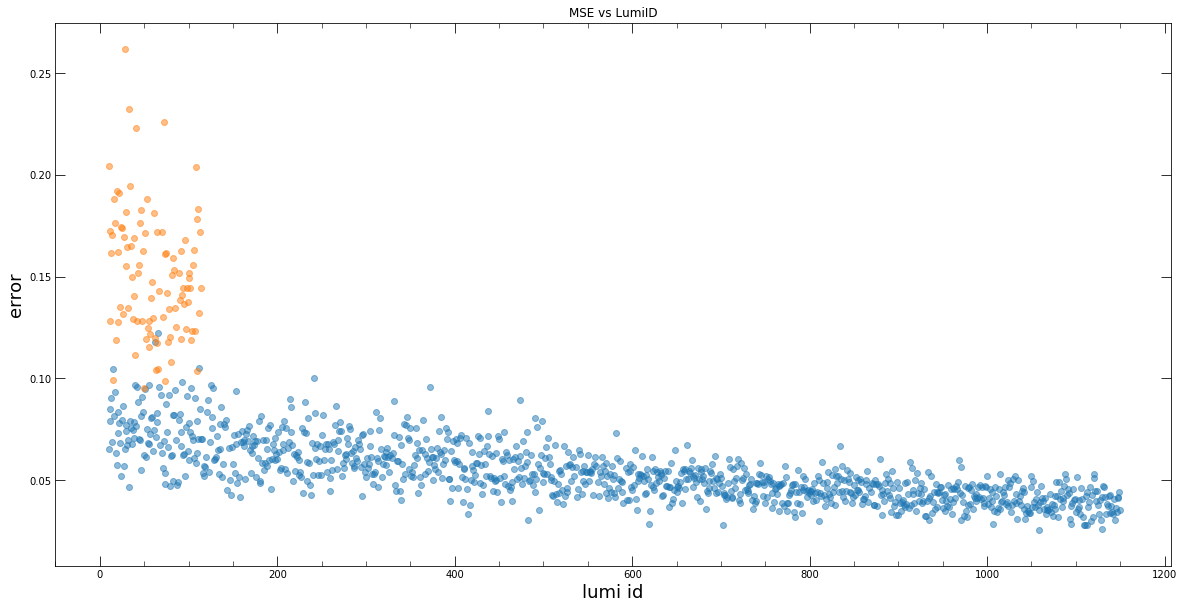

In [77]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
plt.hist(error,bins=bins,label='good',alpha=.5)
plt.hist(error_bad,bins=bins,label='bad',alpha=.5)
plt.title('MSE per sample')

#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
plt.scatter(lumi,error,label='good',alpha=.5)
plt.scatter(lumi_new,error_bad,label='bad',alpha=.5)
plt.xlabel('lumi id')
plt.ylabel('error')
plt.title('MSE vs LumiID')    

plt.show()